In [1]:
import json
import requests
import pandas as pd
import numpy as np
#import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [175]:
days_ago_to_fetch = 250  # see also filter_history_by_date()
coin_history = {}
hist_length = 0
average_returns = {}
cumulative_returns = {}

def fetch_all(coins):
  for coin in coins:
    coin_history[coin] = fetch_history(coin)

def fetch_history(coin):
  endpoint_url = "https://min-api.cryptocompare.com/data/histoday?fsym={}&tsym=USD&limit={:d}".format(coin, days_ago_to_fetch)
  res = requests.get(endpoint_url)
  hist = pd.DataFrame(json.loads(res.content)['Data'])
  hist = index_history(hist)
  hist = filter_history_by_date(hist)
  return hist

def index_history(hist):
  # index by date so we can easily filter by a given timeframe
  hist = hist.set_index('time')
  hist.index = pd.to_datetime(hist.index, unit='s')
  return hist

def filter_history_by_date(hist):
  result = hist # customize here
  # result = hist[hist.index.year >= 2017]
  # result = result[result.index.day == 1] # every first of month, etc.
  return result

def combine_data(ch):
    ndf = pd.DataFrame()
    for coin in coins:
        ndf =pd.concat([ndf, ch[coin]['close']], axis=1, sort=False)
    
    ndf.columns = coins
    
    for coin in coins:
        ndf[coin+'_chng']=ndf[coin].pct_change()*100
        
    for i in range(0, len(coins)):
        coin=coins[i]
        #print( ndf.iat[0, len(coins)+i])
        ndf.iat[0, len(coins)+i]=0
        #print( 'tada', ndf.iloc[0][coin+'_chng'] )
        
    return ndf

def get_extremum(ch_d, orig):
    min_v = {'col':'None', 'offset': 100}
    max_v = {'col':'None', 'offset':-100}
    
    #print('#'*20)
    #print('@',ch_d)
    
    for coin in coins:
        #print(coin, orig[coin+'_share'], ch_d[coin+'_share'],  ch_d[coin+'_share']-orig[coin+'_share'])
        
        new_offset=ch_d[coin+'_share']-orig[coin+'_share']
        if max_v['offset'] < new_offset and new_offset != 0:
            max_v['col']=coin
            max_v['offset']=new_offset
        
        if min_v['offset'] > new_offset and new_offset != 0:
            min_v['col']=coin
            min_v['offset']=new_offset
    
    #print('# min', min_v, 'max', max_v)
    return min_v, max_v

coins = ['ETH', 'ETC', 'BTC', 'XRP', 'MKR', 'BTG', 'EOS']
coins = ['ETH', 'ETC', 'BTC']
fetch_all(coins)

{'ETC_v': 100, 'ETH_v': 30, 'BTC_v': 30, 'ETH_orig_v': 30, 'ETC_orig_v': 100, 'BTC_orig_v': 30, 'ETH_tokens': 0.08437157240487106, 'ETC_tokens': 6.613756613756614, 'BTC_tokens': 0.004773254500383451, 'ETH_orig_tokens': 0.08437157240487106, 'ETC_orig_tokens': 6.613756613756614, 'BTC_orig_tokens': 0.004773254500383451, 'sum': 160, 'sum_orig': 160, 'ETH_sh_orig': 0.1875, 'ETC_sh_orig': 0.625, 'BTC_sh_orig': 0.1875, 'ETH_sh': 0.1875, 'ETC_sh': 0.625, 'BTC_sh': 0.1875}
ETH tokens  0.08437157240487106
ETC tokens  6.613756613756614
BTC tokens  0.004773254500383451
=
ETH share   0.1875
ETC share   0.625
BTC share   0.1875
=
ETH share o 0.1875
ETC share o 0.625
BTC share o 0.1875
=
ETH volume 30
ETC volume 100
BTC volume 30
ETH          355.57
ETC           15.12
BTC         6285.02
ETH_chng       0.00
ETC_chng       0.00
BTC_chng       0.00
ETH_v         30.00
ETC_v        100.00
BTC_v         30.00
sum          160.00
Name: 2018-08-08 00:00:00, dtype: float64
ETH          166.100000
ETC      

,ETH,ETC,BTC,ETH_chng,ETC_chng,BTC_chng,ETH_v,ETC_v,BTC_v,sum
time,,,,,,,,,,
2018-08-08,355.57,15.12,6285.02,0.000000,0.000000,0.000000,30.000000,100.000000,30.000000,160.000000
2018-08-09,363.51,15.02,6543.24,2.233034,-0.661376,4.108499,30.669910,99.338624,31.232550,161.241084
2018-08-10,331.57,14.22,6153.41,-8.786553,-5.326232,-5.957752,27.975082,94.047619,29.371792,151.394493
2018-08-11,318.01,13.21,6242.54,-4.089634,-7.102672,1.448465,26.831004,87.367725,29.797232,143.995961
2018-08-12,318.20,13.18,6322.92,0.059747,-0.227101,1.287617,26.847034,87.169312,30.180906,144.197253


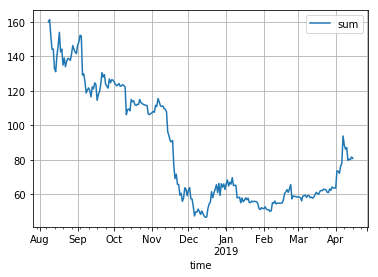

In [176]:
hist_length = len(coin_history[coins[0]])
ndf = combine_data(coin_history)

pf={}
pf['ETC_v']=100
pf['ETH_v']=30
pf['BTC_v']=30
#pf['XRP_v']=100
#pf['MKR_v']=30
#pf['BTG_v']=30
#pf['EOS_v']=100

#prepare portfolio
for coin in coins: pf[coin+'_orig_v'] = pf[coin+'_v']
for coin in coins: pf[coin+'_tokens'] = pf[coin+'_v']/ndf.iloc[0][coin]
for coin in coins: pf[coin+'_orig_tokens'] = pf[coin+'_v']/ndf.iloc[0][coin]
pf['sum']=0
for coin in coins: pf['sum'] += pf[coin+'_v']
pf['sum_orig'] =   pf['sum']
for coin in coins: pf[coin+'_sh_orig'] = pf[coin+'_v']/pf['sum_orig']
for coin in coins: pf[coin+'_sh'] = pf[coin+'_v']/pf['sum']
print(pf)
for coin in coins: print(coin, 'tokens ', pf[coin+'_tokens'])
print('=')
for coin in coins: print(coin, 'share  ', pf[coin+'_sh'])
print('=')
for coin in coins: print(coin, 'share o', pf[coin+'_sh_orig'])
print('=')
for coin in coins: print(coin, 'volume', pf[coin+'_v'])


#prepare dataset
for coin in coins: ndf[coin+'_v'] = pf[coin+'_tokens']*ndf[coin]
ndf['sum']=0
for coin in coins: ndf['sum'] += ndf[coin+'_v']
print(ndf.iloc[0])
print(ndf.iloc[ndf.shape[0]-1])

(ndf['sum']).plot(grid=True, legend=True)

ndf.head()

In [177]:
def gen_cv(cur):
    cv = {}
    for coin in coins: cv[coin+'_v']=pf[coin+'_tokens'] * cur[coin]

    sm = 0
    for coin in coins: sm+=cv[coin+'_v']
    
    for coin in coins: cv[coin+'_sh']=cv[coin+'_v']/sm
    for coin in coins: cv[coin+'_sh_chng']=cv[coin+'_sh']-pf[coin+'_sh']
            
    #for coin in coins: print('{} sm:{:.4f} orig_s:{:.4f} cur:_s{:.4f} chng:{:.4f}'.format(
    #    coin, sm, pf[coin+'_sh_orig'], cv[coin+'_sh'], cv[coin+'_sh_chng']*100))
    #print(coin)
    return cv

def recalculate_pf_values(cur):
    for coin in coins:
        pf[coin+'_v']=pf[coin+'_tokens']*cur[coin]
        
#print(pf)
cva=[]
n = 0
threshold = 2
ctr=0
while n < ndf.shape[0]:
    cur = ndf.iloc[n]
    recalculate_pf_values(cur)

    inspect_loop=True
    added=False
    while inspect_loop:
        cv = gen_cv(cur)
        if added==False:
            cva.append(cv)
            added=True
        
        print(n, cv)
        max_thresh=False
        min_thresh=False
              
        for coin in coins:
            if cv[coin+'_sh_chng']*100 > threshold:
                max_thresh=True
                print('#%'*20, coin, cv[coin+'_sh_chng']*100)
                
                flds = []
                for rec in cv:  
                    if '_sh_chng' in rec: flds.append({'chng':cv[rec], 'nm':rec.replace('_sh_chng','')})
                sflds=sorted(flds, key = lambda k:k['chng'], reverse=False)
                print(sflds)

                nm = sflds[0]['nm']
                for rec in pf:
                    if coin in rec or nm in rec: print(rec,pf[rec])
                        
                        
                excess_tokens = pf[coin+'_tokens']*cv[coin+'_sh_chng']
                excess_value = cur[coin]*excess_tokens
                shortage_tokens = excess_value/cur[nm]
                
                pf[coin+'_tokens']-=excess_tokens * (1-0.001)               
                pf[nm+'_tokens']+=shortage_tokens * (1-0.001)
                recalculate_pf_values(cur)
                
                print('&'*20)
                for rec in pf: 
                    if coin in rec or nm in rec: print(rec,pf[rec])
                ctr+=1
                #if ctr>10:
                #    n=1000000
                #    inspect_loop=False
                
            if cv[coin+'_sh_chng']*100 < -threshold:
                min_thresh=True
                print('#'*20, coin, cv[coin+'_sh_chng']*100)
                flds = []
                for rec in cv:  
                    if '_sh_chng' in rec: flds.append({'chng':cv[rec], 'nm':rec.replace('_sh_chng','')})
                sflds=sorted(flds, key = lambda k:k['chng'], reverse=True)
                print(sflds)

                nm = sflds[0]['nm']
                for rec in pf:
                    if coin in rec or nm in rec: print('pf:', rec, pf[rec])
                
                shortage_tokens = pf[coin+'_tokens']*cv[coin+'_sh_chng']
                shortage_value = shortage_tokens*cur[coin]
                print('sht_tk', shortage_tokens, 'sht_vl', shortage_value)
                target_value = shortage_value*0.2
                excess_tokens = target_value/cur[nm]
                print('tvl', target_value, 'excc tkn', excess_tokens, nm)
                print('prc',cur[coin])
                pf[nm+'_tokens']-=abs(excess_tokens) * (1-0.001)
                pf[coin+'_tokens']+=abs(shortage_tokens) * (1-0.001)
                
                
                print('chng:', cv[nm+'_sh_chng'], 'pf', pf[nm+'_tokens'])
                print('exscess:{:.8f} ex_vl:{:.8f} sht_tkn:{:.8f}'.format(excess_tokens, excess_value, shortage_tokens))
                
                recalculate_pf_values(cur)
                
                print('%'*20)
                for rec in pf: 
                    if coin in rec or nm in rec: print(rec,pf[rec])

                ctr+=1
                #if ctr>10:
                #    n=1000000
                #    inspect_loop=False

        print('ILOOP', inspect_loop, n, max_thresh, min_thresh)
        if max_thresh==False and min_thresh==False: inspect_loop=False
    print('#', n)
    n+=1

0 {'ETH_v': 30.000000000000004, 'ETC_v': 100.0, 'BTC_v': 30.0, 'ETH_sh': 0.18750000000000003, 'ETC_sh': 0.625, 'BTC_sh': 0.1875, 'ETH_sh_chng': 2.7755575615628914e-17, 'ETC_sh_chng': 0.0, 'BTC_sh_chng': 0.0}
ILOOP True 0 False False
# 0
1 {'ETH_v': 30.669910284894677, 'ETC_v': 99.33862433862434, 'BTC_v': 31.232549777089012, 'ETH_sh': 0.19021151091178734, 'ETC_sh': 0.61608754808306, 'BTC_sh': 0.19370094100515264, 'ETH_sh_chng': 0.0027115109117873404, 'ETC_sh_chng': -0.008912451916940012, 'BTC_sh_chng': 0.006200941005152644}
ILOOP True 1 False False
# 1
2 {'ETH_v': 27.975082262283095, 'ETC_v': 94.04761904761905, 'BTC_v': 29.37179197520453, 'ETH_sh': 0.18478269357921967, 'ETC_sh': 0.621208981957542, 'BTC_sh': 0.19400832446323832, 'ETH_sh_chng': -0.00271730642078033, 'ETC_sh_chng': -0.003791018042457961, 'BTC_sh_chng': 0.006508324463238319}
ILOOP True 2 False False
# 2
3 {'ETH_v': 26.831003740473044, 'ETC_v': 87.36772486772487, 'BTC_v': 29.79723214882371, 'ETH_sh': 0.18633164152255355, 'ET

ILOOP True 32 False False
# 32
33 {'ETH_v': 21.176472564087316, 'ETC_v': 78.80749054586978, 'BTC_v': 25.254396495555202, 'ETH_sh': 0.169089347950508, 'ETC_sh': 0.6292600030382474, 'BTC_sh': 0.20165064901124466, 'ETH_sh_chng': -0.018410652049491993, 'ETC_sh_chng': 0.004260003038247362, 'BTC_sh_chng': 0.01415064901124466}
ILOOP True 33 False False
# 33
34 {'ETH_v': 19.888525389270402, 'ETC_v': 78.32016507429638, 'BTC_v': 25.13903439734926, 'ETH_sh': 0.16123949924245648, 'ETC_sh': 0.6349542738839191, 'BTC_sh': 0.20380622687362443, 'ETH_sh_chng': -0.02626050075754352, 'ETC_sh_chng': 0.009954273883919118, 'BTC_sh_chng': 0.01630622687362443}
#################### ETH -2.626050075754352
[{'chng': 0.01630622687362443, 'nm': 'BTC'}, {'chng': 0.009954273883919118, 'nm': 'ETC'}, {'chng': -0.02626050075754352, 'nm': 'ETH'}]
pf: ETH_v 19.888525389270402
pf: BTC_v 25.13903439734926
pf: ETH_orig_v 30
pf: BTC_orig_v 30
pf: ETH_tokens 0.10741844660691548
pf: BTC_tokens 0.0039931498167511065
pf: ETH_orig

ILOOP True 76 False False
# 76
77 {'ETH_v': 22.696572246823038, 'ETC_v': 73.97650137264854, 'BTC_v': 23.810520327471814, 'ETH_sh': 0.18837894441311062, 'ETC_sh': 0.6139964699693895, 'BTC_sh': 0.19762458561749996, 'ETH_sh_chng': 0.0008789444131106217, 'ETC_sh_chng': -0.011003530030610498, 'BTC_sh_chng': 0.01012458561749996}
ILOOP True 77 False False
# 77
78 {'ETH_v': 22.50754599461955, 'ETC_v': 73.52219327824129, 'BTC_v': 23.760959885238375, 'ETH_sh': 0.18789059712318898, 'ETC_sh': 0.6137554400714118, 'BTC_sh': 0.1983539628053992, 'ETH_sh_chng': 0.0003905971231889793, 'ETC_sh_chng': -0.011244559928588194, 'BTC_sh_chng': 0.010853962805399187}
ILOOP True 78 False False
# 78
79 {'ETH_v': 22.746904680841716, 'ETC_v': 73.14360319956857, 'BTC_v': 23.740518041112413, 'ETH_sh': 0.19014218515323575, 'ETC_sh': 0.6114099802801187, 'BTC_sh': 0.19844783456664547, 'ETH_sh_chng': 0.0026421851532357488, 'ETC_sh_chng': -0.013590019719881274, 'BTC_sh_chng': 0.01094783456664547}
ILOOP True 79 False False


113 {'ETH_v': 12.973805173806207, 'ETC_v': 43.85859768446668, 'BTC_v': 14.244435470366549, 'ETH_sh': 0.18253210861489022, 'ETC_sh': 0.6170589282781092, 'BTC_sh': 0.20040896310700063, 'ETH_sh_chng': -0.0049678913851097795, 'ETC_sh_chng': -0.007941071721890847, 'BTC_sh_chng': 0.012908963107000626}
ILOOP True 113 False False
# 113
114 {'ETH_v': 12.464703693969241, 'ETC_v': 40.92877233307518, 'BTC_v': 13.323913222664723, 'ETH_sh': 0.18682840911709658, 'ETC_sh': 0.613464837178916, 'BTC_sh': 0.19970675370398744, 'ETH_sh_chng': -0.0006715908829034167, 'ETC_sh_chng': -0.011535162821084022, 'BTC_sh_chng': 0.012206753703987439}
ILOOP True 114 False False
# 114
115 {'ETH_v': 13.086448017501153, 'ETC_v': 43.32590216603186, 'BTC_v': 13.947929080349821, 'ETH_sh': 0.1859919851713644, 'ETC_sh': 0.6157721745750917, 'BTC_sh': 0.198235840253544, 'ETH_sh_chng': -0.0015080148286356065, 'ETC_sh_chng': -0.009227825424908298, 'BTC_sh_chng': 0.010735840253543988}
ILOOP True 115 False False
# 115
116 {'ETH_v': 

&&&&&&&&&&&&&&&&&&&&
ETC_v 49.719101987955014
ETH_v 17.117992336423985
ETH_orig_v 30
ETC_orig_v 100
ETH_tokens 0.10933124057242119
ETC_tokens 9.072828829918798
ETH_orig_tokens 0.08437157240487106
ETC_orig_tokens 6.613756613756614
ETH_sh_orig 0.1875
ETC_sh_orig 0.625
ETH_sh 0.1875
ETC_sh 0.625
#################### ETC -2.2449781791591628
[{'chng': 0.028085944941432905, 'nm': 'ETH'}, {'chng': -0.005636163149841167, 'nm': 'BTC'}, {'chng': -0.022449781791591628, 'nm': 'ETC'}]
pf: ETC_v 49.719101987955014
pf: ETH_v 17.117992336423985
pf: ETH_orig_v 30
pf: ETC_orig_v 100
pf: ETH_tokens 0.10933124057242119
pf: ETC_tokens 9.072828829918798
pf: ETH_orig_tokens 0.08437157240487106
pf: ETC_orig_tokens 6.613756613756614
pf: ETH_sh_orig 0.1875
pf: ETC_sh_orig 0.625
pf: ETH_sh 0.1875
pf: ETC_sh 0.625
sht_tk -0.2036830274641386 sht_vl -1.1161829905034797
tvl -0.22323659810069596 excc tkn -0.0014257942013201506 ETH
prc 5.48
chng: 0.028085944941432905 pf 0.10790687216530236
exscess:-0.00142579 ex_vl:0.

195 {'ETH_v': 14.706437365952315, 'ETC_v': 46.8327676232026, 'BTC_v': 14.103937027671112, 'ETH_sh': 0.19441864753160337, 'ETC_sh': 0.6191277407908987, 'BTC_sh': 0.186453611677498, 'ETH_sh_chng': 0.006918647531603372, 'ETC_sh_chng': -0.005872259209101283, 'BTC_sh_chng': -0.0010463883225020065}
ILOOP True 195 False False
# 195
196 {'ETH_v': 15.198349363719277, 'ETC_v': 47.848662799410896, 'BTC_v': 14.2829569406602, 'ETH_sh': 0.1965389297300821, 'ETC_sh': 0.618759626493444, 'BTC_sh': 0.18470144377647388, 'ETH_sh_chng': 0.009038929730082107, 'ETC_sh_chng': -0.006240373506556041, 'BTC_sh_chng': -0.002798556223526122}
ILOOP True 196 False False
# 196
197 {'ETH_v': 14.906053828814272, 'ETC_v': 46.12164099985679, 'BTC_v': 14.149940940264173, 'ETH_sh': 0.19827776806694586, 'ETC_sh': 0.6135021476548627, 'BTC_sh': 0.1882200842781915, 'ETH_sh_chng': 0.010777768066945859, 'ETC_sh_chng': -0.011497852345137338, 'BTC_sh_chng': 0.0007200842781915073}
ILOOP True 197 False False
# 197
198 {'ETH_v': 15.17

Index(['BTC_sh', 'BTC_sh_chng', 'BTC_v', 'ETC_sh', 'ETC_sh_chng', 'ETC_v',
       'ETH_sh', 'ETH_sh_chng', 'ETH_v', 'sum'],
      dtype='object')


,BTC_sh,BTC_sh_chng,BTC_v,ETC_sh,ETC_sh_chng,ETC_v,ETH_sh,ETH_sh_chng,ETH_v,sum
246,0.194592,0.007092,20.103221,0.595878,-0.029122,61.559919,0.209530,0.022030,21.646396,103.309536
247,0.191412,0.003912,20.234387,0.612549,-0.012451,64.753108,0.196039,0.008539,20.723421,105.710917
248,0.192316,0.004816,20.231042,0.610724,-0.014276,64.246433,0.196960,0.009460,20.719643,105.197119
249,0.191564,0.004064,20.569231,0.610604,-0.014396,65.563789,0.197832,0.010332,21.242262,107.375282
250,0.193444,0.005944,20.522921,0.609393,-0.015607,64.651773,0.197162,0.009662,20.917357,106.092051


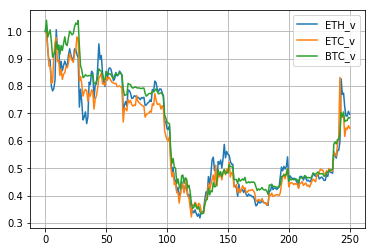

In [178]:
dfcv=pd.DataFrame(cva)
dfcv['sum']=0

print(dfcv.columns)
for coin in coins:
    dfcv['sum'] += dfcv[coin+'_v']
    (dfcv[coin+'_v']/dfcv.loc[0][coin+'_v']).plot(grid=True, legend=True)
dfcv.tail()

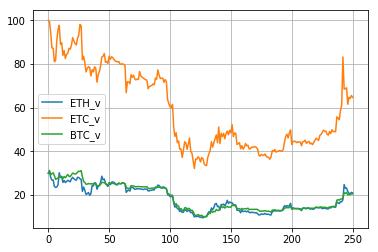

In [179]:
for coin in coins:
    (dfcv[coin+'_v']).plot(grid=True, legend=True)

,sum_reb
246,103.309536
247,105.710917
248,105.197119
249,107.375282
250,106.092051


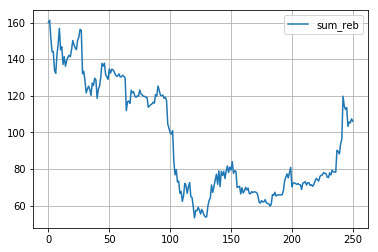

In [180]:
r1=pd.DataFrame(dfcv['sum'])
r1.columns=['sum_reb']
r1['sum_reb'].plot(grid=True, legend=True)
#dfcv['sum'].plot(grid=True, legend=True)
r1.reset_index()
r1.tail()

,sum_reb,time,sum
0,160.000000,2018-08-08,160.000000
1,161.241084,2018-08-09,161.241084
2,151.394493,2018-08-10,151.394493
3,143.995961,2018-08-11,143.995961
4,144.197253,2018-08-12,144.197253


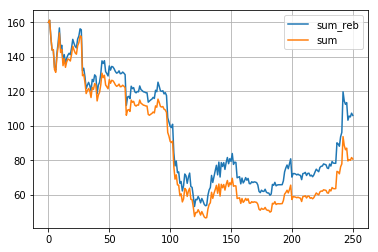

In [181]:
r2 = ndf['sum']
r2=r2.reset_index()

r2=pd.concat([r1, r2], axis=1, sort=False)

r2['sum_reb'].plot(grid=True, legend=True)
r2['sum'].plot(grid=True, legend=True)

r2.head(5)


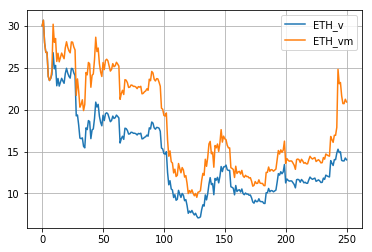

In [197]:
#ndf.head()
#dfcv.head()
s1=pd.DataFrame(ndf['ETH_v'])
s1 = s1.reset_index()
s2=pd.DataFrame(dfcv['ETH_v'])
sr = pd.concat([s1, s2], axis=1, sort=False)
sr.columns = ['time','ETH_v','ETH_vm']
sr['ETH_v'].plot(grid=True, legend=True)
sr['ETH_vm'].plot(grid=True, legend=True)